<a href="https://colab.research.google.com/github/rliu7926/weinstein-ligo-research/blob/main/4.4%20Spin%20Distribution%20Calculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'
! pip install astropy
! pip install sympy

from astropy.cosmology import FlatLambdaCDM, Planck18, z_at_value
import astropy.units as u

import numpy as np
from numpy import diff
from numpy import trapz
import pylab
import math
import scipy

import matplotlib.pyplot as plt

import scipy
import scipy.integrate as integrate
from scipy.integrate import quad 

from pycbc import waveform
from pycbc.waveform import get_td_waveform, get_fd_waveform

import pycbc
import pycbc.noise
import pycbc.psd

from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pandas as pd
from pycbc.types import TimeSeries
from random import randint

import seaborn as sns
from mpl_toolkits import mplot3d
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import time

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 28.5 MB 64 kB/s 
     |████████████████████████████████| 1.6 MB 33.0 MB/s 
     |████████████████████████████████| 52 kB 961 kB/s 
     |████████████████████████████████| 1.0 MB 33.4 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 3.2 MB 33.1 MB/s 


In [ ]:
## Create waveform function (taken from Section 3.1)

def create_waveform(mass1=30, mass2=30, spin1=[0, 0, 0], spin2=[0, 0, 0], resolution=1.0/1024, frequencybound=20, distance=500, cosmology=Planck18, approximant="IMRPhenomPv2"):

  redshift = 1 + z_at_value(cosmology.comoving_distance, distance * u.Mpc)
  lum_dist = cosmology.luminosity_distance(redshift-1).value
  fbound = frequencybound * redshift

  waveform, waveform_cross = get_td_waveform(approximant=approximant,
                                             mass1=mass1, mass2=mass2,
                                             spin1x=spin1[0], spin1y=spin1[1], spin1z=spin1[2],
                                             spin2x=spin2[0], spin2y=spin2[1], spin2z=spin2[2],
                                             delta_t=resolution/redshift,
                                             f_lower=fbound)
  
  waveform_amplitude = [0] * len(waveform)
  waveform_time = [0] * len(waveform)

  for i in range(len(waveform)):
    waveform_amplitude[i] = waveform[i]
    waveform_time[i] = waveform.sample_times[i]

  waveform_amplitude = [i/lum_dist for i in waveform_amplitude]
  waveform_time = [i*redshift for i in waveform_time]

  waveform_amplitude = np.array(waveform_amplitude)
  waveform_time = np.array(waveform_time)

  return waveform_amplitude, waveform_time

In [ ]:
## Create frequency series waveform function (for expectation value function)

def create_fd_waveform(mass1, mass2, spin1, spin2, fres, flow, dist, cosmology=Planck18, approximant="IMRPhenomPv2"):

  redshift = 1 + z_at_value(cosmology.comoving_distance, dist * u.Mpc)
  lum_dist = cosmology.luminosity_distance(redshift-1)
  flow_bound = flow * redshift

  hplus, hcross = get_fd_waveform(approximant=approximant,
                                  mass1=mass1, mass2=mass2,
                                  spin1x=spin1[0], spin1y=spin1[1], spin1z=spin1[2],
                                  spin2x=spin2[0], spin2y=spin2[1], spin2z=spin2[2],
                                  delta_f=fres * redshift,
                                  f_lower=flow_bound)
  
  freq_value = hplus.sample_frequencies / redshift
  freq_amp = hplus / lum_dist * redshift

  return freq_amp, freq_value


In [ ]:
## Expectation value function (taken from 4.1)

def expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, dist, tdist, psd, cosmology=Planck18, approximant="IMRPhenomD", output="Yes"):

  ## Create waveform and template

  gw_amp, gw_value = create_fd_waveform(mass1=mass1, mass2=mass2, spin1=spin1, spin2=spin2, fres=fres, flow=flow, dist=dist, approximant=approximant)
  signal_amp, signal_value = create_fd_waveform(mass1=tmass1, mass2=tmass2, spin1=tspin1, spin2=tspin2, fres=fres, flow=flow, dist=tdist, approximant=approximant)

  gwfreq = pycbc.types.frequencyseries.FrequencySeries(initial_array=gw_amp, delta_f=fres)
  signalfreq = pycbc.types.frequencyseries.FrequencySeries(initial_array=signal_amp, delta_f=fres)

  ## Create PSD 

  flen = len(gw_value)

  if psd == 'aLIGOAPlusDesignSensitivityT1800042':
    psdfreq = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, fres, flow)
  
  if psd == 'aLIGODesignSensitivityP1200087':
    psdfreq = pycbc.psd.aLIGODesignSensitivityP1200087(flen, fres, flow)

  if psd == 'CosmicExplorerP1600143':
    psdfreq = pycbc.psd.CosmicExplorerP1600143(flen, fres, flow)
    

  ## Calculate SNR

  gwdata = gwfreq + psdfreq
  snr = matched_filter(template=signalfreq, data=gwdata, psd=psdfreq, low_frequency_cutoff=flow)

  if output == 'Yes':
    print("The signal-to-noise ratio is: {}".format(max(abs(snr))))
  
  return(max(abs(snr)))
  

In [ ]:
## Distance estimation function, updated with new parameters

def estimate_distance(snr, guess, alpha, iterations, tolerance, mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, dist='param', psd='aLIGODesignSensitivityP1200087', cosmology=Planck18, approximant='IMRPhenomD', output='Yes'): 
  
  if dist == 'param':
    pred = guess
    estimate = expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, guess, guess, psd, cosmology, approximant)
    print("Initial guess: {}".format(estimate))

    diff = 1
    iter = 0

    while iter < iterations and abs(diff) > tolerance:
      diff = snr - estimate
      pred = pred + alpha * diff
      estimate = expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, res, fres, flow, pred, pred, psd, cosmology, approximant)
      iter = iter + 1
      print("Iteration {}: Estimate {}, Distance {}".format(iter, estimate, pred))
    
  else: 
    print("Nothing to estimate: distance needs to be set to param")

  print("Final estimate: {}, off by {}".format(pred, diff))
  return(pred, diff) 

In [ ]:
## Distance estimation function for varying spins in the z-direction 

spins = np.arange(-0.9, 1, 0.1)

aligo, aplus, cosmic = (np.zeros((len(spins), len(spins))) for i in range(3))
dist = [aligo, aplus, cosmic]
guess = [6000, 7000, 11000]
alpha = [-100, -100, -20]
psd = ['aLIGODesignSensitivityP1200087', 'aLIGOAPlusDesignSensitivityT1800042', 'CosmicExplorerP1600143']

for i in range(len(dist)):
  for s in range(len(spins)):
    for t in range(len(spins)):
        dist[i][s][t], error = estimate_distance(snr=8, guess=guess[i], alpha=alpha[i], iterations=200, tolerance=10**-4,
                                                 mass1=30, mass2=30, spin1=[0,0,spins[s]], spin2=[0,0,spins[t]],
                                                 tmass1=30, tmass2=30, tspin1=[0,0,spins[s]], tspin2=[0,0,spins[s]],
                                                 res=1.0/1024, fres=1.0/16, flow=20, dist='param', psd=psd[i], cosmology=Planck18)
        print("--------------------------------------------- PSD: {}, Spin: {}, {}".format(psd[i], spins[s], spins[t]))

for i in range(len(dist)):
  for r in range(len(spins)):
    for c in range(len(spins)):
      dist[i][r][c] = z_at_value(Planck18.comoving_distance, dist[i][r][c] * u.Mpc)


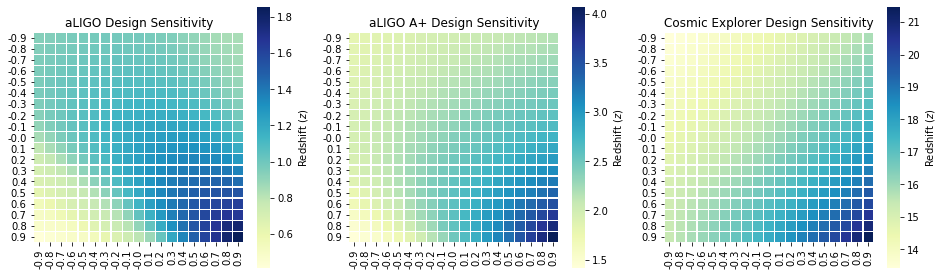

In [ ]:
fig = plt.figure(figsize = (16.0,4.8))

snrtitle=['aLIGO', 'aLIGO A+', 'Cosmic Explorer']

spins = np.arange(-0.9, 1, 0.1)
spins = np.around(spins, decimals=1)

for i in range(len(dist)):
  heatmap = pd.DataFrame(dist[i], columns=spins, index=spins)
  pos = fig.add_subplot(1,3, i+1)
  sns.heatmap(heatmap, ax=pos, linewidths=0.25, cmap="YlGnBu", square="True", cbar_kws={'label': 'Redshift ($z$)'}).set(title="{} Design Sensitivity".format(snrtitle[i]))


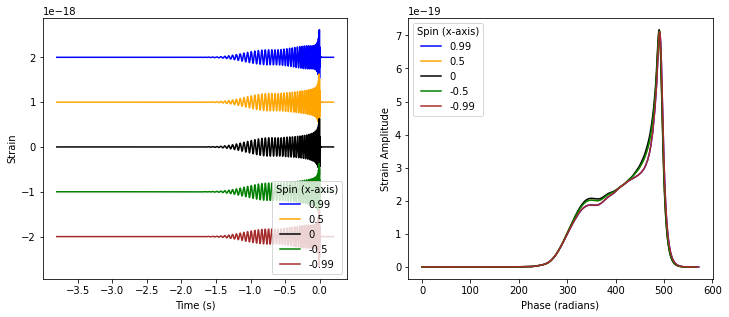

In [ ]:
## Visualization for varying spins in the x-direction 

normalamp, normaltime = create_waveform(distance=1, approximant='IMRPhenomPv2')
spin5xamp, spin5xtime = create_waveform(spin1=[0.5, 0, 0], spin2=[0.5, 0, 0], distance=1, approximant='IMRPhenomPv2')
spinneg5xamp, spinneg5xtime = create_waveform(spin1=[-0.5, 0, 0], spin2=[-0.5, 0, 0], distance=1, approximant='IMRPhenomPv2')
spin9xamp, spin9xtime = create_waveform(spin1=[0.99, 0, 0], spin2=[0.99, 0, 0], distance=1, approximant='IMRPhenomPv2')
spinneg9xamp, spinneg9xtime = create_waveform(spin1=[-0.99, 0, 0], spin2=[-0.99, 0, 0], distance=1, approximant='IMRPhenomPv2')

fig = plt.figure(figsize=(12, 4.8))

plt.subplot(1,2,1)

plt.plot(spin9xtime, spin9xamp + 2 * 10**-18, color = "blue")
plt.plot(spin5xtime, spin5xamp + 1 * 10**-18, color = "orange")
plt.plot(normaltime, normalamp, color="black")
plt.plot(spinneg5xtime, spinneg5xamp - 1 * 10**-18, color = "green")
plt.plot(spinneg9xtime, spinneg9xamp - 2 * 10**-18, color = "brown")
plt.legend(labels=[0.99, 0.5, 0, -0.5, -0.99], title="Spin (x-axis)")
plt.ylabel("Strain")
plt.xlabel("Time (s)")

plt.subplot(1,2,2)

spins = [0.99, 0.5, 0, -0.5, -0.99]
colors = ["blue", "orange", "black", "green", "brown"]
for i in range(len(spins)):
    hp, hc = get_td_waveform(approximant="IMRPhenomPv2", mass1=30, mass2=30, spin1x=spins[i], delta_t=1.0/1024, f_lower=20)
    hp, hc = hp.trim_zeros(), hc.trim_zeros()
    amp = waveform.utils.amplitude_from_polarizations(hp, hc)
    phase = waveform.utils.phase_from_polarizations(hp, hc)
    pylab.plot(phase, amp, color = colors[i])

plt.legend(labels=[0.99, 0.5, 0, -0.5, -0.99], title="Spin (x-axis)")
plt.ylabel("Strain Amplitude")
plt.xlabel("Phase (radians)")
fig.show()


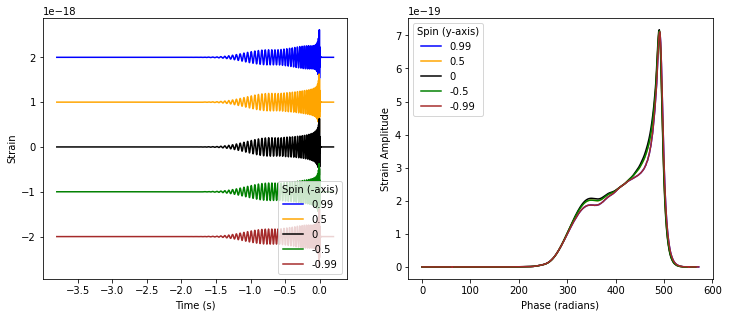

In [ ]:
## Visualization for varying spins in the y-direction 

normalamp, normaltime = create_waveform(distance=1, approximant='IMRPhenomPv2')
spin5yamp, spin5ytime = create_waveform(spin1=[0, 0.5, 0], spin2=[0, 0.5, 0], distance=1, approximant='IMRPhenomPv2')
spinneg5yamp, spinneg5ytime = create_waveform(spin1=[0, -0.5, 0], spin2=[0, -0.5, 0], distance=1, approximant='IMRPhenomPv2')
spin9yamp, spin9ytime = create_waveform(spin1=[0, 0.99, 0], spin2=[0, 0.99, 0], distance=1, approximant='IMRPhenomPv2')
spinneg9yamp, spinneg9ytime = create_waveform(spin1=[0, -0.99, 0], spin2=[0, -0.99, 0], distance=1, approximant='IMRPhenomPv2')

fig = plt.figure(figsize=(12, 4.8))

plt.subplot(1,2,1)

plt.plot(spin9ytime, spin9yamp + 2 * 10**-18, color = "blue")
plt.plot(spin5ytime, spin5yamp + 1 * 10**-18, color = "orange")
plt.plot(normaltime, normalamp, color="black")
plt.plot(spinneg5ytime, spinneg5yamp - 1 * 10**-18, color = "green")
plt.plot(spinneg9ytime, spinneg9yamp - 2 * 10**-18, color = "brown")
plt.legend(labels=[0.99, 0.5, 0, -0.5, -0.99], title="Spin (y-axis)")
plt.ylabel("Strain")
plt.xlabel("Time (s)")

plt.subplot(1,2,2)

spins = [0.99, 0.5, 0, -0.5, -0.99]
colors = ["blue", "orange", "black", "green", "brown"]
for i in range(len(spins)):
    hp, hc = get_td_waveform(approximant="IMRPhenomPv2", mass1=30, mass2=30, spin1y=spins[i], delta_t=1.0/1024, f_lower=20)
    hp, hc = hp.trim_zeros(), hc.trim_zeros()
    amp = waveform.utils.amplitude_from_polarizations(hp, hc)
    phase = waveform.utils.phase_from_polarizations(hp, hc)
    pylab.plot(phase, amp, color = colors[i])

plt.legend(labels=[0.99, 0.5, 0, -0.5, -0.99], title="Spin (y-axis)")
plt.ylabel("Strain Amplitude")
plt.xlabel("Phase (radians)")
fig.show()


In [ ]:
## Distance estimation function for varying spins in the x- and y-directions

spins = np.arange(-0.7, 0.8, 0.1)

aligo, aplus, cosmic = (np.zeros((len(spins), len(spins))) for i in range(3))
dist = [aligo, aplus, cosmic]
guess = [6000, 7000, 11000]
alpha = [-100, -100, -20]
psd = ['aLIGODesignSensitivityP1200087', 'aLIGOAPlusDesignSensitivityT1800042', 'CosmicExplorerP1600143']

for i in range(len(dist)):
  for s in range(len(spins)):
    for t in range(len(spins)):
        dist[i][s][t], error = estimate_distance(snr=8, guess=guess[i], alpha=alpha[i], iterations=200, tolerance=10**-4,
                                                 mass1=30, mass2=30, spin1=[spins[s], spins[t], 0], spin2=[0,0,0],
                                                 tmass1=30, tmass2=30, tspin1=[spins[s], spins[t], 0], tspin2=[0,0,0],
                                                 res=1.0/1024, fres=1.0/16, flow=20, dist='param', psd=psd[i], cosmology=Planck18, approximant='IMRPhenomPv2')
        print("--------------------------------------------- PSD: {}, Spin: {}, {}".format(psd[i], spins[s], spins[t]))

for i in range(len(dist)):
  for r in range(len(spins)):
    for c in range(len(spins)):
      dist[i][r][c] = z_at_value(Planck18.comoving_distance, dist[i][r][c] * u.Mpc)


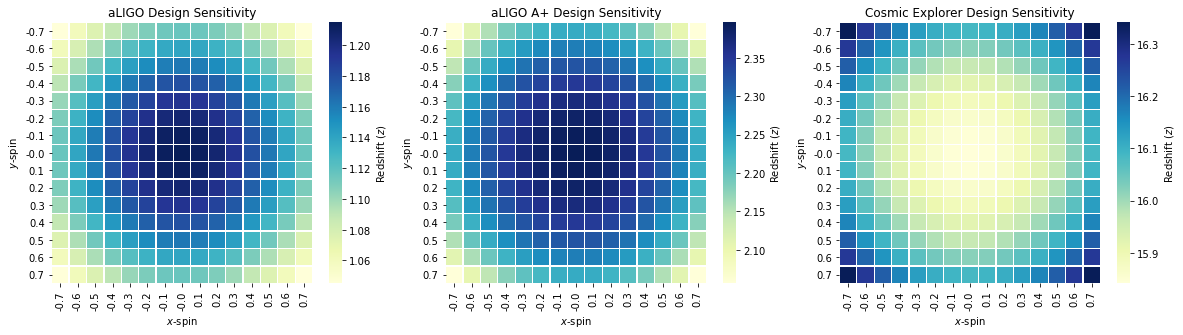

In [ ]:
fig = plt.figure(figsize = (20.0,4.8))

snrtitle=['aLIGO', 'aLIGO A+', 'Cosmic Explorer']

spins = np.arange(-0.7, 0.8, 0.1)
spins = np.around(spins, decimals=1)

for i in range(len(dist)):
  heatmap = pd.DataFrame(dist[i], columns=spins, index=spins)
  pos = fig.add_subplot(1,3, i+1)
  sns.heatmap(heatmap, ax=pos, linewidths=0.25, cmap="YlGnBu", square="True", cbar_kws={'label': 'Redshift ($z$)'}).set(title="{} Design Sensitivity".format(snrtitle[i]), xlabel="$x$-spin", ylabel="$y$-spin")


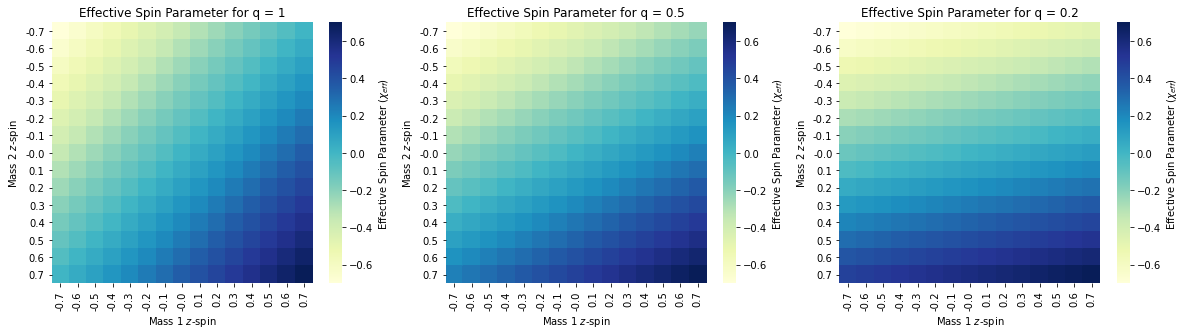

In [ ]:
## Effective spin parameter

def chieff(q, s1z, s2z):
  return (s1z + q*s2z) / (1 + q)

## Plot effective spin parameter

zspins = np.arange(-0.7, 0.8, 0.1)
chieff1, chieff3, chieff5 = (np.zeros((len(zspins), len(zspins))) for i in range(3))

for i in range(len(zspins)):
  for j in range(len(zspins)):
    chieff1[i][j] = chieff(1, zspins[i], zspins[j])
    chieff3[i][j] = chieff(0.5, zspins[i], zspins[j])
    chieff5[i][j] = chieff(0.2, zspins[i], zspins[j])

chieffs = [chieff1, chieff3, chieff5]
ratios = ["1", "0.5", "0.2"]

fig = plt.figure(figsize = (20.0, 4.8))
zspins = np.around(zspins, decimals=2)

for i in range(len(chieffs)):
  heatmap = pd.DataFrame(chieffs[i], columns=zspins, index=zspins)
  pos = fig.add_subplot(1,3, i+1)
  sns.heatmap(heatmap, ax=pos, linewidths=0, cmap="YlGnBu", square="True", cbar_kws={'label': 'Effective Spin Parameter ($\chi_{eff}$)'}).set(title="Effective Spin Parameter for q = {}".format(ratios[i]), xlabel="Mass 1 $z$-spin", ylabel="Mass 2 $z$-spin")


In [ ]:
chieff1_dist, chieff3_dist, chieff5_dist = (np.zeros((len(zspins), len(zspins))) for i in range(3))
chieff_dists = [chieff1_dist, chieff3_dist, chieff5_dist]
qvals = [1, 0.5, 0.2]

for i in range(len(chieff_dists)):
  for j in range(len(zspins)):
    for k in range(len(zspins)):
      chieff_dists[i][j][k], error = estimate_distance(snr=8, guess=3000, alpha=-100, iterations=200, tolerance=0.001,
                                                       mass1=50, mass2=50*qvals[i], spin1=[0, 0, zspins[j]], spin2=[0, 0, zspins[k]],
                                                       tmass1=50, tmass2=50*qvals[i], tspin1=[0, 0, zspins[j]], tspin2=[0, 0, zspins[k]],
                                                       res=1.0/1024, fres=1.0/16, flow=20, approximant='IMRPhenomPv2')
      print("--------------------------------------------- Mass ratio: {}, Spin 1: {}, Spin 2: {}".format(qvals[i], zspins[j], zspins[k]))

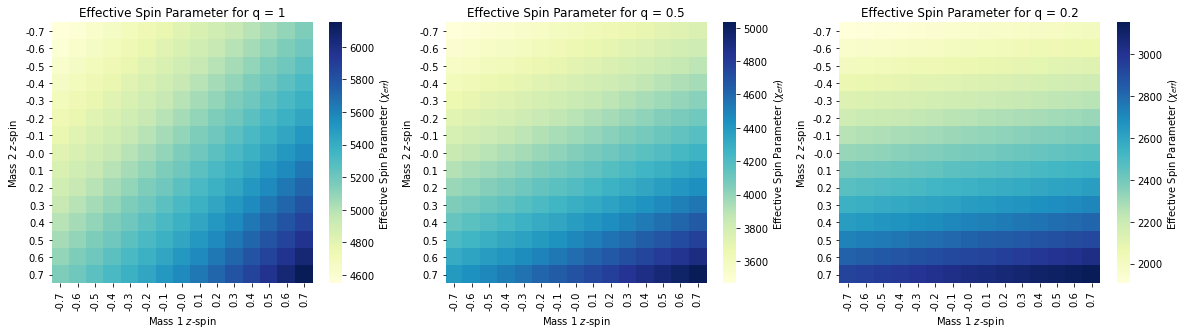

In [ ]:
fig = plt.figure(figsize = (20.0, 4.8))
zspins = np.around(zspins, decimals=2)

for i in range(len(chieffs)):
  heatmap = pd.DataFrame(chieff_dists[i], columns=zspins, index=zspins)
  pos = fig.add_subplot(1,3, i+1)
  sns.heatmap(heatmap, ax=pos, linewidths=0, cmap="YlGnBu", square="True", cbar_kws={'label': 'Effective Spin Parameter ($\chi_{eff}$)'}).set(title="Effective Spin Parameter for q = {}".format(ratios[i]), xlabel="Mass 1 $z$-spin", ylabel="Mass 2 $z$-spin")


In [ ]:
pylab.plot(chieff1_dist, chieff1)
pylab.plot(chieff3_dist, chieff3)
pylab.plot(chieff5_dist, chieff5)

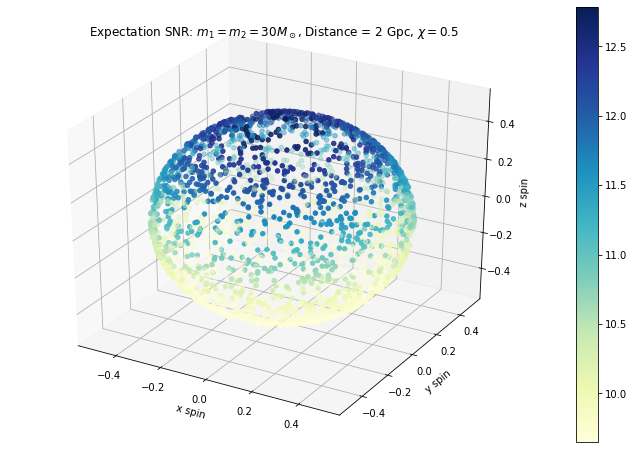

In [ ]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
x, y, z = (get_truncated_normal(mean=0, sd=1, low=-1, upp=1) for i in range(3))
xvals = x.rvs(2500)
yvals = y.rvs(2500)
zvals = z.rvs(2500)

for i in range(2500):
  r = np.sqrt(xvals[i]**2 + yvals[i]**2 + zvals[i]**2)
  xvals[i] = xvals[i] / (2*r)
  yvals[i] = yvals[i] / (2*r)
  zvals[i] = zvals[i] / (2*r)

snr = [0] * 2500
for i in range(len(snr)):
  snr[i] = expectation_SNR(mass1=30, mass2=30, spin1=[xvals[i], yvals[i], zvals[i]], spin2=[xvals[i], yvals[i], zvals[i]],
                           tmass1=30, tmass2=30, tspin1=[xvals[i], yvals[i], zvals[i]], tspin2=[xvals[i], yvals[i], zvals[i]],
                           res=1.0/1024, fres=1.0/16, flow=20, dist=2000, tdist=2000, psd='aLIGODesignSensitivityP1200087', cosmology=Planck18, approximant='IMRPhenomPv2', output='No')

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection ='3d')
p = ax.scatter(xvals, yvals, zvals, c=snr, cmap="YlGnBu")
ax.set_xlabel('x spin')
ax.set_ylabel('y spin')
ax.set_zlabel('z spin')
fig.colorbar(p, ax=ax)
 
# syntax for plotting
ax.set_title('Expectation SNR: $m_1 = m_2 = 30 M_\odot$, Distance = 2 Gpc, $\chi = 0.5$ ')
plt.show()

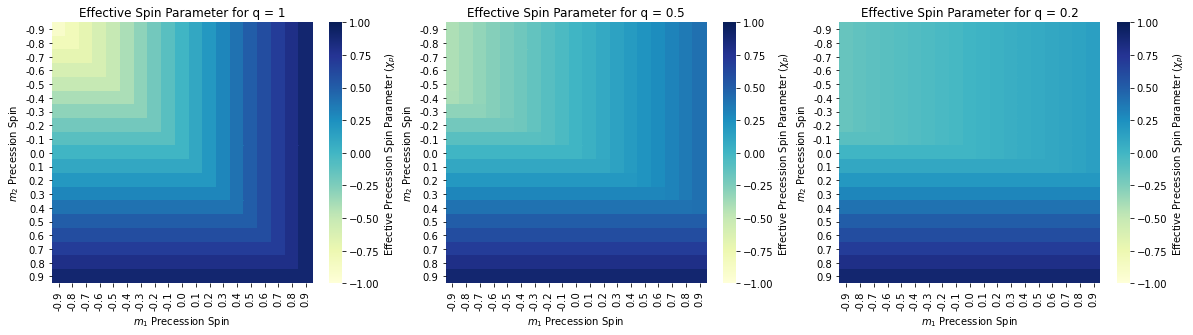

In [ ]:
## EFfective precession spin parameter
def chip(q, s1xy, s2xy):
  return max(s1xy, (4*q+3)/(4+3*q)*q*s2xy)

spin1, spin2 = (np.linspace(-0.9, 0.9, 19) for i in range(2))
chipvals1, chipvals2, chipvals5 = (np.zeros((len(spin1), len(spin2))) for i in range(3))

for i in range(len(spin1)):
  for j in range(len(spin2)):
    chipvals1[i][j] = chip(1, spin1[i], spin2[j])
    chipvals2[i][j] = chip(0.5, spin1[i], spin2[j])
    chipvals5[i][j] = chip(0.2, spin1[i], spin2[j])

chipvals = [chipvals1, chipvals2, chipvals5]
ratios = [1, 0.5, 0.2]

fig = plt.figure(figsize=(20, 4.8))

for i in range(len(chipvals)):
  heatmap = pd.DataFrame(chipvals[i], columns=np.around(spin1, decimals=1), index=np.around(spin2, decimals=1))
  pos = fig.add_subplot(1,3, i+1)
  sns.heatmap(heatmap, vmin=-1, vmax=1, ax=pos, linewidths=0, cmap="YlGnBu", square="True", cbar_kws={'label': 'Effective Precession Spin Parameter ($\chi_{p}$)'}).set(title="Effective Spin Parameter for q = {}".format(ratios[i]), xlabel="$m_1$ Precession Spin", ylabel="$m_2$ Precession Spin")


In [ ]:
## Determine the agreement between effective spin and component spins
spins = np.linspace(-0.8, 0.8, 21)
snr1, snr2, snr5 = (np.zeros((len(spins), len(spins))) for i in range(3))
snr1eff, snr2eff, snr5eff = (np.zeros((len(spins), len(spins))) for i in range(3))

qvals = [1, 1/2, 1/5]
snr = [snr1, snr2, snr5]
snreff = [snr1eff, snr2eff, snr5eff]

for i in range(len(spins)):
  for j in range(len(spins)):
    for q in range(len(snr)):
      snr[q][i][j] = expectation_SNR(mass1=50, mass2=50*qvals[q], spin1=[0,0,spins[i]], spin2=[0,0,spins[j]],
                                     tmass1=50, tmass2=50*qvals[q], tspin1=[0,0,spins[i]], tspin2=[0,0,spins[j]],
                                     res=1.0/1024, fres=1.0/16, flow=20, dist=500, tdist=500,
                                     psd='aLIGODesignSensitivityP1200087', approximant='IMRPhenomPv2')
      
      effspin = (spins[i] + q*spins[j]) / (1 + q)

      snreff[q][i][j] = expectation_SNR(mass1=50, mass2=50*qvals[q], spin1=[0,0,effspin], spin2=[0,0,0],
                                        tmass1=50, tmass2=50*qvals[q], tspin1=[0,0,effspin], tspin2=[0,0,0],
                                        res=1.0/1024, fres=1.0/16, flow=20, dist=500, tdist=500,
                                        psd='aLIGODesignSensitivityP1200087', approximant='IMRPhenomPv2')
       

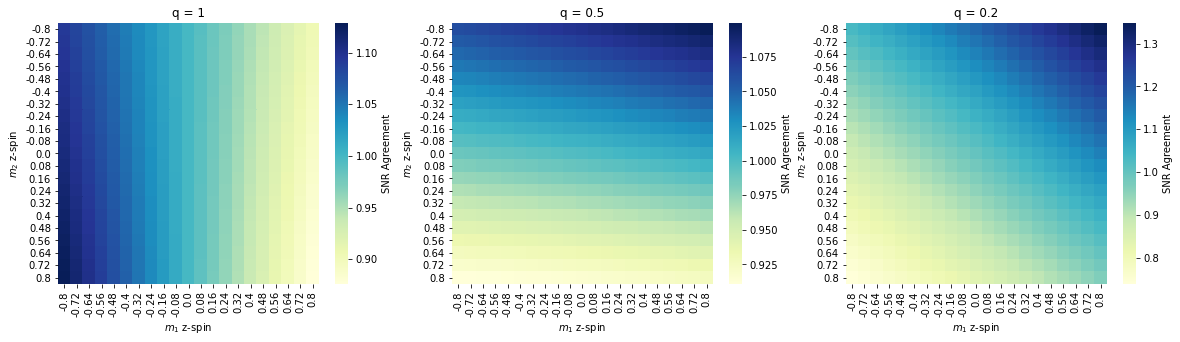

In [ ]:
fig = plt.figure(figsize=(20, 4.8))

for i in range(len(snr)):
  heatmap = pd.DataFrame(snreff[i]/snr[i], columns=np.around(spins, decimals=2), index=np.around(spins, decimals=2))
  pos = fig.add_subplot(1,3, i+1)
  sns.heatmap(heatmap, ax=pos, linewidths=0, cmap="YlGnBu", square="True", cbar_kws={'label': 'SNR Agreement'}).set(title="q = {}".format(np.around(qvals[i], decimals=2)), xlabel="$m_1$ z-spin", ylabel="$m_2$ z-spin")


In [ ]:
## Determine the effect of precessing spin on SNR

spins = np.linspace(-0.98, 0.98, 99)
snr1, snr2, snr5 = ([0] * len(spins) for i in range(3))

qvals = [1, 1/2, 1/5]
snr = [snr1, snr2, snr5]

for q in range(len(snr)):
  for i in range(len(spins)):
    snr[q][i] = expectation_SNR(mass1=50, mass2=50*qvals[q], spin1=[spins[i],0,0], spin2=[spins[i],0,0],
                                tmass1=50, tmass2=50*qvals[q], tspin1=[spins[i],0,0], tspin2=[spins[i],0,0],
                                res=1.0/1024, fres=1.0/16, flow=20, dist=500, tdist=500,
                                psd='aLIGODesignSensitivityP1200087', approximant='IMRPhenomPv2')



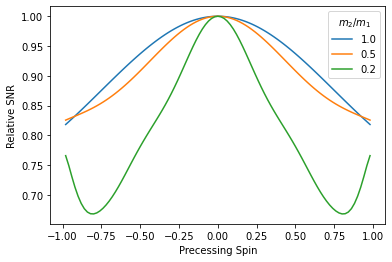

In [ ]:
for i in range(len(snr)):
  pylab.plot(spins, snr[i]/snr[i][49])

plt.xlabel("Precessing Spin")
plt.ylabel("Relative SNR")
plt.legend(labels=[1.0, 0.5, 0.2], title="$m_2/m_1$")

In [ ]:
## Determine the effect of aligned spin on SNR

spins = np.linspace(-0.98, 0.98, 99)
snr1, snr2, snr5 = ([0] * len(spins) for i in range(3))

qvals = [1, 1/2, 1/5]
snr = [snr1, snr2, snr5]

for q in range(len(snr)):
  for i in range(len(spins)):
    snr[q][i] = expectation_SNR(mass1=50, mass2=50*qvals[q], spin1=[0,0,spins[i]], spin2=[0,0,spins[i]],
                                tmass1=50, tmass2=50*qvals[q], tspin1=[0,0,spins[i]], tspin2=[0,0,spins[i]],
                                res=1.0/1024, fres=1.0/16, flow=20, dist=500, tdist=500,
                                psd='aLIGODesignSensitivityP1200087', approximant='IMRPhenomPv2')


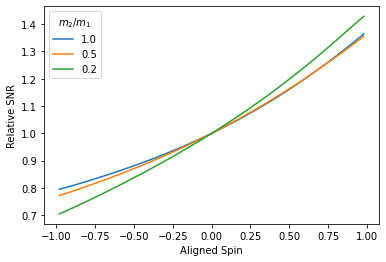

In [ ]:
for i in range(len(snr)):
  pylab.plot(spins, snr[i]/snr[i][49])

plt.xlabel("Aligned Spin")
plt.ylabel("Relative SNR")
plt.legend(labels=[1.0, 0.5, 0.2], title="$m_2/m_1$")

In [ ]:
## Determine agreement between effective precession spin and actual precession spins

def chip(q, s1xy, s2xy):
  return max(s1xy, (4*q+3)/(4+3*q)*q*s2xy)

spins = np.linspace(-0.8, 0.8, 21)
snr1, snr2, snr5 = (np.zeros((len(spins), len(spins))) for i in range(3))
snr1eff, snr2eff, snr5eff = (np.zeros((len(spins), len(spins))) for i in range(3))

qvals = [1, 1/2, 1/5]
snr = [snr1, snr2, snr5]
snreff = [snr1eff, snr2eff, snr5eff]

for i in range(len(spins)):
  for j in range(len(spins)):
    for q in range(len(snr)):
      snr[q][i][j] = expectation_SNR(mass1=50, mass2=50*qvals[q], spin1=[spins[i], 0, 0], spin2=[spins[j], 0, 0],
                                     tmass1=50, tmass2=50*qvals[q], tspin1=[spins[i], 0, 0], tspin2=[spins[j], 0, 0],
                                     res=1.0/1024, fres=1.0/16, flow=20, dist=500, tdist=500,
                                     psd='aLIGODesignSensitivityP1200087', approximant='IMRPhenomPv2')
      
      effspin = chip(qvals[q], spins[i], spins[j])

      snreff[q][i][j] = expectation_SNR(mass1=50, mass2=50*qvals[q], spin1=[effspin,0,0], spin2=[0,0,0],
                                        tmass1=50, tmass2=50*qvals[q], tspin1=[effspin,0,0], tspin2=[0,0,0],
                                        res=1.0/1024, fres=1.0/16, flow=20, dist=500, tdist=500,
                                        psd='aLIGODesignSensitivityP1200087', approximant='IMRPhenomPv2')
       

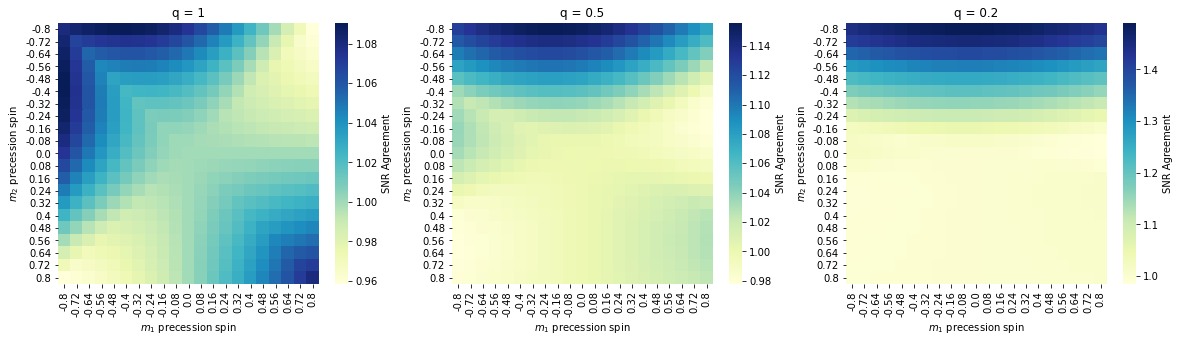

In [ ]:
fig = plt.figure(figsize=(20, 4.8))

for i in range(len(snr)):
  heatmap = pd.DataFrame(snreff[i]/snr[i], columns=np.around(spins, decimals=2), index=np.around(spins, decimals=2))
  pos = fig.add_subplot(1,3, i+1)
  sns.heatmap(heatmap, ax=pos, linewidths=0, cmap="YlGnBu", square="True", cbar_kws={'label': 'SNR Agreement'}).set(title="q = {}".format(np.around(qvals[i], decimals=2)), xlabel="$m_1$ precession spin", ylabel="$m_2$ precession spin")


[Text(51.0, 0.5, '$\\chi_{p}$'),
 Text(0.5, 58.68505263157894, '$\\chi_{eff}$'),
 Text(0.5, 1.0, 'Spin Distribution')]

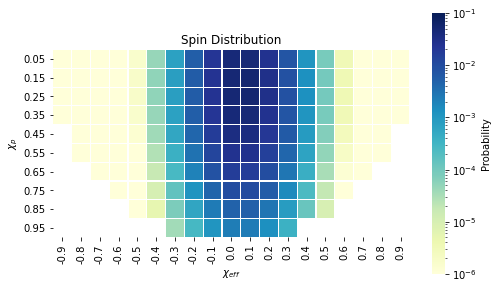

In [ ]:
## Create spin distribution heatmap 

# Effective spin histogram (chi_eff)

x_values_eff = np.linspace(-1, 1, 5001)
y_values_eff = scipy.stats.norm(0.06, 0.12).pdf(x_values_eff)

bins_eff = np.linspace(-0.95, 0.95, 20)
chieff_bins = [0] * (len(bins_eff)-1)

for i in range(len(bins_eff)-1):
  chieff_bins[i] = trapz(y=np.array(y_values_eff)[(250*i+125):(250*i+375),], x=np.array(x_values_eff)[(250*i+125):(250*i+375),])

# Effective precessing spin histogram (chi_p)

x_values_p = np.linspace(0, 1, 5001)
y_values_p = scipy.stats.norm(0.2, 0.3).pdf(x_values_p)

bins_p = np.linspace(0, 1, 11)
chip_bins = [0] * (len(bins_p)-1)

for i in range(len(bins_p)-1):
  chip_bins[i] = trapz(y=np.array(y_values_p)[500*i:(500*i+500),], x=np.array(x_values_p)[500*i:(500*i+500),])

# Combine chi_eff and chi_p into a matrix 

spin_dist = np.zeros((len(chip_bins), len(chieff_bins)))

for i in range(len(chip_bins)):
  for j in range(len(chieff_bins)):
    spin_dist[i][j] = (chip_bins[i]/sum(chip_bins)) * (chieff_bins[j]/sum(chieff_bins))

# Plot histogram

newbins_eff = np.linspace(-0.9, 0.9, 19)
newbins_p = np.linspace(0.05, 0.95, 10)

for i in range(len(newbins_p)):
  for j in range(len(newbins_eff)):
    if (newbins_p[i]**2 + newbins_eff[j]**2) > 1:
      spin_dist[i][j] = 0

spin_dist = spin_dist / sum(sum(spin_dist))

fig = plt.figure(figsize=(8, 4.8))
heatmap = pd.DataFrame(spin_dist, columns=np.around(newbins_eff, decimals=2), index=np.around(newbins_p, decimals=2))
sns.heatmap(heatmap, norm=LogNorm(vmin=10**-6, vmax=0.1), ax=fig.add_subplot(1,1,1), linewidths=0.1, cmap="YlGnBu", square="True", cbar_kws={'label': 'Probability'}).set(title="Spin Distribution", xlabel="$\chi_{eff}$", ylabel="$\chi_{p}$")

In [ ]:
## Determine spread of SNR over spin distribution bins

snrvals1, snrvals2, snrvals3, snrvals4 = (np.zeros((len(newbins_p), len(newbins_eff))) for i in range(4))
snrvals = [snrvals1, snrvals2, snrvals3, snrvals4]

mass1 = [50, 50, 20, 20]
mass2 = [50, 10, 20, 4]

for s in range(len(snrvals)):
  for i in range(len(newbins_p)):
    for j in range(len(newbins_eff)):
      if spin_dist[i][j] == 0:
        snrvals[s][i][j] = 0
      else: 
        snrvals[s][i][j] = expectation_SNR(mass1=mass1[s], mass2=mass2[s], spin1=[newbins_p[i], 0, newbins_eff[j]], spin2=[0,0,0],
                                           tmass1=mass1[s], tmass2=mass2[s], tspin1=[newbins_p[i], 0, newbins_eff[j]], tspin2=[0,0,0],
                                           res=1.0/1024, fres=1.0/16, flow=20, dist=500, tdist=500,
                                           psd='aLIGODesignSensitivityP1200087', approximant='IMRPhenomPv2')

[Text(767.7272727272725, 0.5, '$\\chi_{p}$'),
 Text(0.5, 85.75119617224885, '$\\chi_{eff}$'),
 Text(0.5, 1.0, '$m_1 = 20 M_\\odot, m_2 = 4 M_\\odot$')]

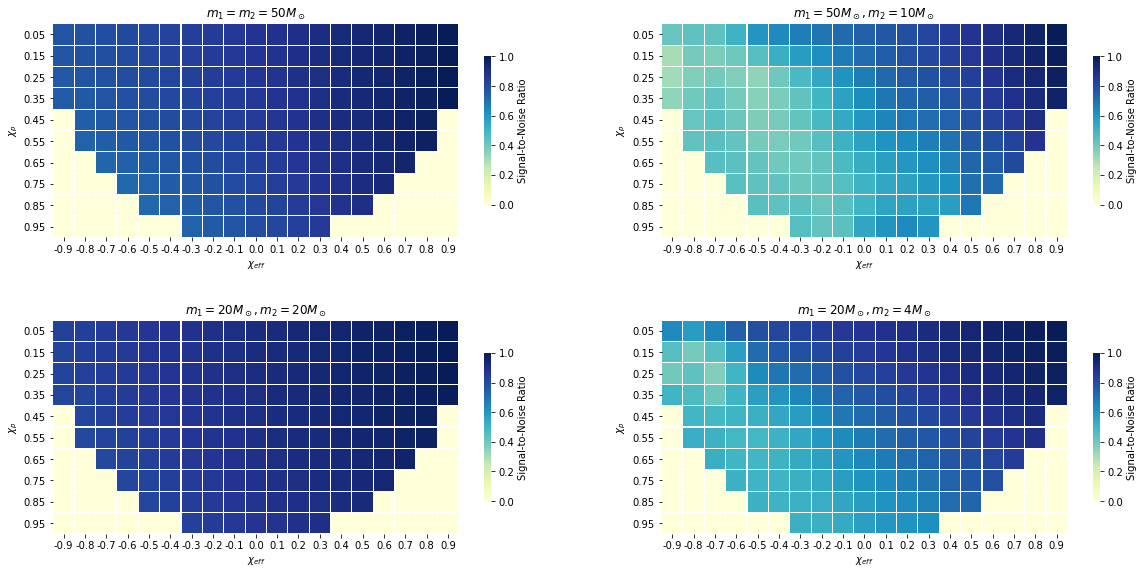

In [ ]:
fig = plt.figure(figsize=(20, 10))

heatmap1 = pd.DataFrame(snrvals1/np.amax(snrvals1), columns=np.around(newbins_eff, decimals=2), index=np.around(newbins_p, decimals=2))
heatmap2 = pd.DataFrame(snrvals2/np.amax(snrvals2), columns=np.around(newbins_eff, decimals=2), index=np.around(newbins_p, decimals=2))
heatmap3 = pd.DataFrame(snrvals3/np.amax(snrvals3), columns=np.around(newbins_eff, decimals=2), index=np.around(newbins_p, decimals=2))
heatmap4 = pd.DataFrame(snrvals4/np.amax(snrvals4), columns=np.around(newbins_eff, decimals=2), index=np.around(newbins_p, decimals=2))

sns.heatmap(heatmap1, vmin=0, vmax=1, ax=fig.add_subplot(2,2,1), linewidths=0.1, cmap="YlGnBu", square="True", cbar_kws={'label': 'Signal-to-Noise Ratio', 'shrink': 0.6}).set(title="$m_1 = m_2 = 50 M_\odot$", xlabel="$\chi_{eff}$", ylabel="$\chi_{p}$")
sns.heatmap(heatmap2, vmin=0, vmax=1, ax=fig.add_subplot(2,2,2), linewidths=0.1, cmap="YlGnBu", square="True", cbar_kws={'label': 'Signal-to-Noise Ratio', 'shrink': 0.6}).set(title="$m_1 = 50 M_\odot, m_2 = 10 M_\odot$", xlabel="$\chi_{eff}$", ylabel="$\chi_{p}$")
sns.heatmap(heatmap3, vmin=0, vmax=1, ax=fig.add_subplot(2,2,3), linewidths=0.1, cmap="YlGnBu", square="True", cbar_kws={'label': 'Signal-to-Noise Ratio', 'shrink': 0.6}).set(title="$m_1 = 20 M_\odot, m_2 = 20 M_\odot$", xlabel="$\chi_{eff}$", ylabel="$\chi_{p}$")
sns.heatmap(heatmap4, vmin=0, vmax=1, ax=fig.add_subplot(2,2,4), linewidths=0.1, cmap="YlGnBu", square="True", cbar_kws={'label': 'Signal-to-Noise Ratio', 'shrink': 0.6}).set(title="$m_1 = 20 M_\odot, m_2 = 4 M_\odot$", xlabel="$\chi_{eff}$", ylabel="$\chi_{p}$")
